## Imports

In [1]:
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt

# Data

In [2]:
data = pd.read_csv('new_Exam_Score_Prediction.csv')

y = data['exam_score']
X = data.drop('exam_score', axis=1)

data

,study_hours,class_attendance,facility_rating,gender,coaching,self_study,exam_score
0,2.78,92.9,0,1,1,0,58.9
1,7.88,76.8,2,1,1,0,90.3
2,0.89,71.6,0,0,1,0,43.7
3,3.48,65.4,0,1,0,0,58.2
4,1.35,69.0,2,0,0,0,53.7
...,...,...,...,...,...,...,...
13269,5.74,81.4,2,1,0,0,95.0
13270,3.28,73.3,2,0,0,0,93.9
13271,3.71,41.6,1,1,1,0,60.9
13272,4.60,76.3,1,1,0,1,79.0


# Models

In [3]:
PATH = 'pipes'
pipe_names = os.listdir(PATH)[:-1] #Gitignore file to not pushing the models
pipe_names = [n.strip('.pkl') for n in pipe_names]

pipes = {}

for name in pipe_names:
    with open(os.path.join(PATH, name + '.pkl'), 'rb') as f:
        pipes[name] = pickle.load(f)

pipes

{'XSB': Pipeline(steps=[('sclaer', StandardScaler()),
                 ('regressor',
                  XGBRegressor(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7555702646479975, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.007669548993428671, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3, max_leaves=None,
                               min_child_weight=3, mis

# Friedman test

## Results for testing
Bootstrap

In [4]:
import numpy as np
from sklearn.metrics import r2_score

results = {n: [] for n in pipe_names}

idx = np.arange(0, data.shape[0])
for i in range(10):
    print("Iteration:", i)
    Boot_idx = np.random.choice(idx, size=int(10e3), replace=True, p=None)
    x_boot, y_boot = X.iloc[Boot_idx], y.iloc[Boot_idx]
    for idx, model in enumerate(pipes.values()):

        model.fit(x_boot, y_boot)
        preds = model.predict(x_boot)
        score = r2_score(y_boot, preds)

        results[pipe_names[idx]].append(score)


results_df = pd.DataFrame.from_dict(results, orient='index')
results_df

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


,0,1,2,3,4,5,6,7,8,9
XSB,0.677783,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998
Tree,0.671174,0.999789,0.999795,0.999794,0.999782,0.999781,0.999795,0.999791,0.999783,0.999788
SVR,0.666239,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Forest,0.705469,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Linear,0.664744,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Friedman Test

In [5]:
from scipy.stats import friedmanchisquare

# Extract the lists from the dictionary
model_results = [results[i] for i in results]

# Run the test
stat, p = friedmanchisquare(*model_results)

print(stat)
print(f"P-value: {p}")

31.895287958115194
P-value: 2.0097199917632146e-06


# Nemenyi Test
We need perform another test as the p-value in fridman test is low enough to reject null hypothesis

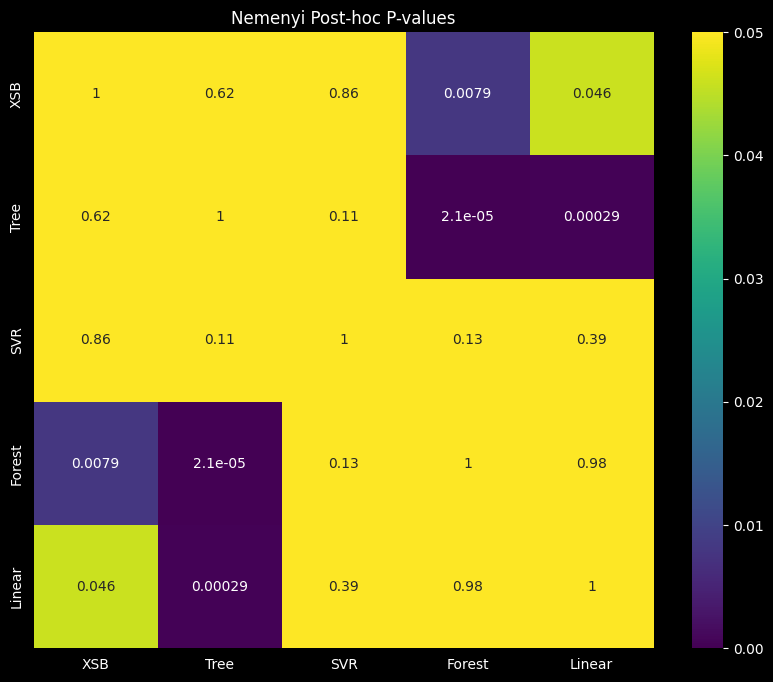

In [6]:
import scikit_posthocs as sp
import seaborn as sns

nemenyi_results = sp.posthoc_nemenyi_friedman(results_df.T)

plt.figure(figsize=(10, 8))
sns.heatmap(nemenyi_results, annot=True, cmap='viridis', vmin=0, vmax=0.05)
plt.title("Nemenyi Post-hoc P-values")
plt.show()

# Means of Model Results

In [7]:
results_df.mean(axis=1)

XSB       0.967777
Tree      0.966927
SVR       0.966624
Forest    0.970547
Linear    0.966474
dtype: float64